In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **A Music Recommendation System based on Genre & Mood**

#Music Genre Classification

In [ ]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [ ]:
# Section 1: Feature Extraction for Traditional ML Models
# Extracts MFCCs, spectral centroid, and chroma features for SVM, RF, k-NN
def extract_mfcc_features(file_path):
    """
    Extracts audio features (MFCC mean/variance, spectral centroid, chroma) from a WAV file.
    Args:
        file_path (str): Path to the audio file.
    Returns:
        np.array: Concatenated feature vector (39 dimensions) or None if extraction fails.
    """
    try:
        y, sr = librosa.load(file_path, sr=22050)  # Load audio with 22kHz sampling rate
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # 13 MFCC coefficients
        centroid = librosa.feature.spectral_centroid(y=y, sr=sr)  # Spectral centroid
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)  # Chroma features
        features = np.concatenate([
            np.mean(mfcc, axis=1), np.var(mfcc, axis=1),  # MFCC statistics
            np.mean(centroid, axis=1), np.mean(chroma, axis=1)  # Other features
        ])
        return features
    except Exception as e:
        print(f"Error in MFCC extraction for {file_path}: {str(e)}")
        return None

# Section 2: Feature Extraction for CNN
# Extracts Mel-spectrograms for CNN input
def extract_spectrogram(file_path):
    """
    Extracts a normalized Mel-spectrogram from a WAV file for CNN input.
    Args:
        file_path (str): Path to the audio file.
    Returns:
        np.array: Mel-spectrogram (128x128) or None if extraction fails.
    """
    try:
        y, sr = librosa.load(file_path, sr=22050)  # Load audio
        spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)  # 128 Mel bands
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)  # Convert to dB
        # Ensure fixed size (128x128)
        if spectrogram_db.shape[1] > 128:
            spectrogram_db = spectrogram_db[:, :128]
        else:
            spectrogram_db = np.pad(spectrogram_db, ((0, 0), (0, 128 - spectrogram_db.shape[1])), mode='constant')
        # Normalize to [0, 1]
        spectrogram_db = (spectrogram_db - spectrogram_db.min()) / (spectrogram_db.max() - spectrogram_db.min())
        return spectrogram_db
    except Exception as e:
        print(f"Error in spectrogram extraction for {file_path}: {str(e)}")
        return None

In [ ]:
# Section 3: Load GTZAN Dataset
# Loads audio files, extracts features, and stores labels and file paths
data_dir = "/content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Data/genres_original"
genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]  # 10 genres
X_mfcc = []  # MFCC features for traditional models
X_spec = []  # Spectrograms for CNN
y = []       # Genre labels (0-9)
file_paths = []

for genre_idx, genre in enumerate(genres):
    genre_path = os.path.join(data_dir, genre)
    if not os.path.exists(genre_path):
        print(f"Genre folder not found: {genre_path}")
        continue
    files = [f for f in os.listdir(genre_path) if f.endswith(".wav")]
    print(f"Found {len(files)} files in {genre_path}")
    for file_name in files:
        file_path = os.path.join(genre_path, file_name)
        mfcc = extract_mfcc_features(file_path)
        spec = extract_spectrogram(file_path)
        if mfcc is not None and spec is not None:
            X_mfcc.append(mfcc)
            X_spec.append(spec)
            y.append(genre_idx)
            file_paths.append(file_path)
        else:
            print(f"Skipping {file_path} due to extraction failure")

# Convert lists to NumPy arrays for processing
X_mfcc = np.array(X_mfcc)
X_spec = np.array(X_spec)
y = np.array(y)
file_paths = np.array(file_paths)
print(f"Loaded samples: {len(y)} (should be 1000 for full GTZAN)")
print(f"X_mfcc shape: {X_mfcc.shape}, X_spec shape: {X_spec.shape}, y shape: {y.shape}, file_paths length: {len(file_paths)}")

# Section 4: Split Data into Train and Test Sets
# Splits features, labels, and file paths with stratification
if len(y) < 10:
    raise ValueError("Too few samples loaded. Check dataset integrity.")
try:
    X_mfcc_train, X_mfcc_test, X_spec_train, X_spec_test, y_train, y_test, file_train, file_test = train_test_split(
        X_mfcc, X_spec, y, file_paths, test_size=0.2, random_state=42, stratify=y
    )
    print(f"Train samples: {len(y_train)}, Test samples: {len(y_test)}")
except Exception as e:
    print(f"Error in data splitting: {str(e)}")
    raise

# Section 5: Scale MFCC Features
# Standardizes MFCC features for traditional ML models
scaler = StandardScaler()
X_mfcc_train_scaled = scaler.fit_transform(X_mfcc_train)  # Fit and transform training data
X_mfcc_test_scaled = scaler.transform(X_mfcc_test)       # Transform test data
full_mfcc_scaled = np.vstack((X_mfcc_train_scaled, X_mfcc_test_scaled))  # Full dataset for recommender
full_y = np.concatenate((y_train, y_test))               # Full labels
full_file_paths = np.concatenate((file_train, file_test)) # Full file paths

# Section 6: Plot Confusion Matrix
# Visualizes model performance with a heatmap
def plot_confusion_matrix(y_true, y_pred, title, genres):
    """
    Plots a confusion matrix using Seaborn heatmap.
    Args:
        y_true (np.array): True labels.
        y_pred (np.array): Predicted labels.
        title (str): Plot title.
        genres (list): Genre names for axis labels.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=genres, yticklabels=genres)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Section 7: Train and Evaluate Traditional ML Models
# Trains SVM, Random Forest, and k-NN with hyperparameter tuning
traditional_models = {
    "SVM": GridSearchCV(SVC(random_state=42), {'C': [0.1, 1, 10], 'kernel': ['rbf']}, cv=5),
    "Random Forest": GridSearchCV(RandomForestClassifier(random_state=42),
                                  {'n_estimators': [100, 200], 'max_depth': [10, 20, None]}, cv=5),
    "k-NN": GridSearchCV(KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]}, cv=5)
}

Found 100 files in /content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Data/genres_original/blues
Found 100 files in /content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Data/genres_original/classical
Found 100 files in /content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Data/genres_original/country
Found 100 files in /content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Data/genres_original/disco
Found 100 files in /content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Data/genres_original/hiphop
Found 100 files in /content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Data/genres_original/jazz


<ipython-input-4-4ed96ec55f5c>:12: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=22050)  # Load audio with 22kHz sampling rate
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error in MFCC extraction for /content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Data/genres_original/jazz/jazz.00054.wav: 


<ipython-input-4-4ed96ec55f5c>:36: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=22050)  # Load audio
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error in spectrogram extraction for /content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Data/genres_original/jazz/jazz.00054.wav: 
Skipping /content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Data/genres_original/jazz/jazz.00054.wav due to extraction failure
Found 100 files in /content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Data/genres_original/metal
Found 100 files in /content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Data/genres_original/pop
Found 100 files in /content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Data/genres_original/reggae
Found 100 files in /content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Data/genres_original/rock
Loaded samples: 999 (should be 1000 for full GTZAN)
X_mfcc shape: (999, 39), X_spec shape: (999, 128, 128), y shape: (999,), file_paths length: 999
Train samples: 799, Test samples: 200



Training SVM...

=== SVM ===
Best Params: {'C': 10, 'kernel': 'rbf'}
Accuracy: 70.50%
Classification Report:
              precision    recall  f1-score   support

       blues       0.58      0.70      0.64        20
   classical       0.86      0.90      0.88        20
     country       0.62      0.75      0.68        20
       disco       0.65      0.75      0.70        20
      hiphop       0.63      0.85      0.72        20
        jazz       0.89      0.80      0.84        20
       metal       0.89      0.85      0.87        20
         pop       0.76      0.65      0.70        20
      reggae       0.55      0.55      0.55        20
        rock       0.71      0.25      0.37        20

    accuracy                           0.70       200
   macro avg       0.72      0.70      0.70       200
weighted avg       0.72      0.70      0.70       200



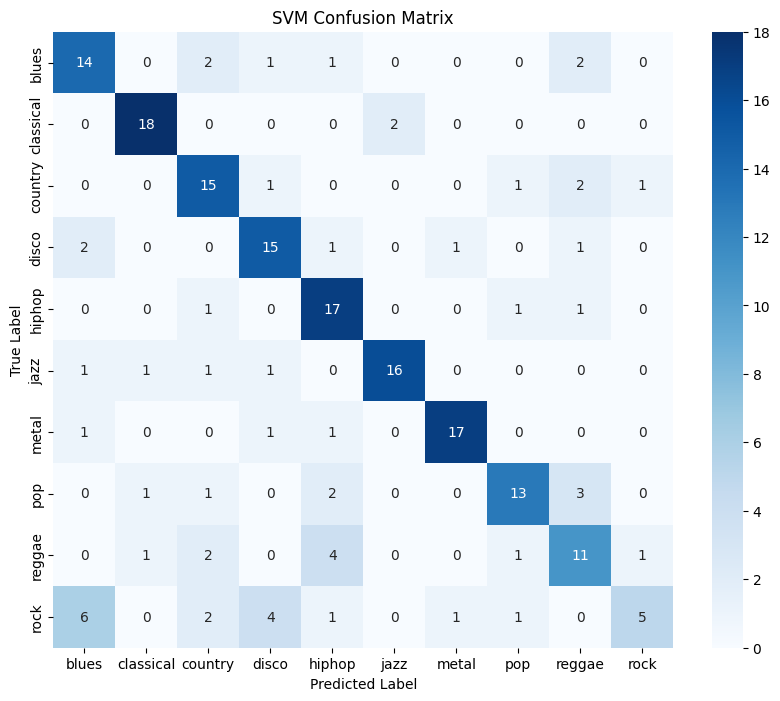


Training Random Forest...

=== Random Forest ===
Best Params: {'max_depth': 20, 'n_estimators': 200}
Accuracy: 66.50%
Classification Report:
              precision    recall  f1-score   support

       blues       0.60      0.45      0.51        20
   classical       1.00      0.90      0.95        20
     country       0.57      0.80      0.67        20
       disco       0.58      0.75      0.65        20
      hiphop       0.50      0.60      0.55        20
        jazz       0.76      0.80      0.78        20
       metal       0.85      0.85      0.85        20
         pop       0.67      0.80      0.73        20
      reggae       0.71      0.50      0.59        20
        rock       0.40      0.20      0.27        20

    accuracy                           0.67       200
   macro avg       0.66      0.67      0.65       200
weighted avg       0.66      0.67      0.65       200



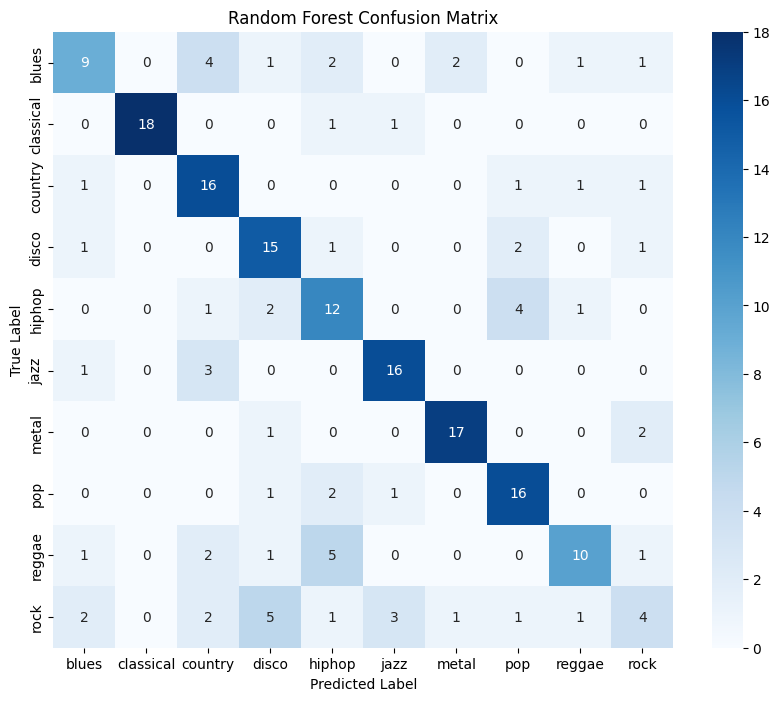


Training k-NN...

=== k-NN ===
Best Params: {'n_neighbors': 7}
Accuracy: 64.50%
Classification Report:
              precision    recall  f1-score   support

       blues       0.56      0.50      0.53        20
   classical       1.00      0.85      0.92        20
     country       0.53      0.80      0.64        20
       disco       0.54      0.75      0.62        20
      hiphop       0.53      0.50      0.51        20
        jazz       0.74      0.85      0.79        20
       metal       0.84      0.80      0.82        20
         pop       0.73      0.80      0.76        20
      reggae       0.50      0.35      0.41        20
        rock       0.50      0.25      0.33        20

    accuracy                           0.65       200
   macro avg       0.65      0.65      0.63       200
weighted avg       0.65      0.65      0.63       200



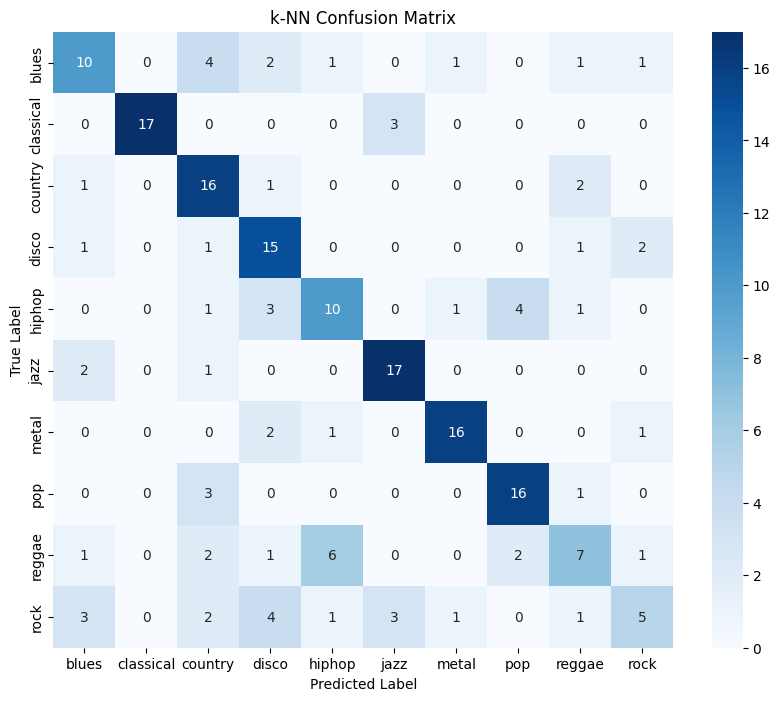

In [ ]:
results = {}         # Store model accuracies
trained_models = {}  # Store trained models
for name, model in traditional_models.items():
    try:
        print(f"\nTraining {name}...")
        model.fit(X_mfcc_train_scaled, y_train)  # Train model with scaled MFCCs
        y_pred = model.predict(X_mfcc_test_scaled)  # Predict on test set
        accuracy = accuracy_score(y_test, y_pred)   # Compute accuracy
        results[name] = accuracy
        trained_models[name] = model
        print(f"\n=== {name} ===")
        print(f"Best Params: {model.best_params_}")
        print(f"Accuracy: {accuracy * 100:.2f}%")
        print("Classification Report:")
        print(classification_report(y_test, y_pred, target_names=genres))
        plot_confusion_matrix(y_test, y_pred, f"{name} Confusion Matrix", genres)
    except Exception as e:
        print(f"Error in {name} training/evaluation: {str(e)}")

X_spec_train shape: (799, 128, 128, 1), X_spec_test shape: (200, 128, 128, 1)

Training CNN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 24s 936ms/step - accuracy: 0.0984 - loss: 2.3144 - val_accuracy: 0.2500 - val_loss: 2.2879
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 39s 855ms/step - accuracy: 0.1604 - loss: 2.2600 - val_accuracy: 0.2250 - val_loss: 2.0887
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 945ms/step - accuracy: 0.2995 - loss: 2.0158 - val_accuracy: 0.3375 - val_loss: 1.8133
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 40s 911ms/step - accuracy: 0.3056 - loss: 1.8754 - val_accuracy: 0.2750 - val_loss: 1.9024
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 40s 855ms/step - accuracy: 0.3666 - loss: 1.7410 - val_accuracy: 0.4375 - val_loss: 1.6494
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 22s 900ms/step - accuracy: 0.3721 - loss: 1.7423 - val_accuracy: 0.4250 - val_loss: 1.5958
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 939ms/step - accuracy: 0.4136 - loss: 1.5217 - val_accuracy: 0.4125 - val_loss: 1.5047
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 39s 868ms/step - accuracy: 0.4774 - loss: 1.4404 - val_accu

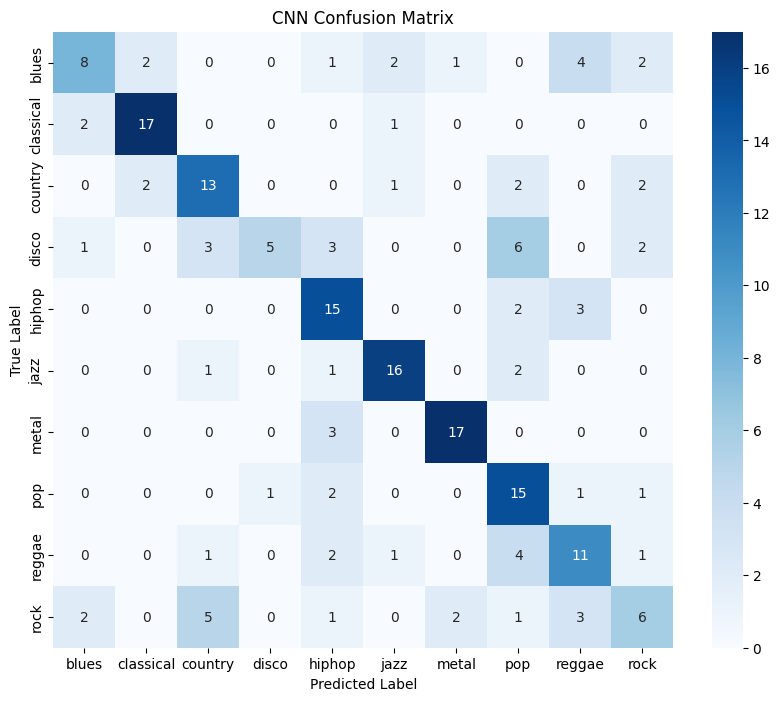

In [ ]:
# Section 8: Train and Evaluate CNN
# Trains a convolutional neural network on Mel-spectrograms
X_spec_train = X_spec_train[..., np.newaxis]  # Add channel dimension (800, 128, 128, 1)
X_spec_test = X_spec_test[..., np.newaxis]    # (200, 128, 128, 1)
print(f"X_spec_train shape: {X_spec_train.shape}, X_spec_test shape: {X_spec_test.shape}")

# Define CNN architecture
cnn_model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),  # Prevent overfitting
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')  # 10 genres
])

# Compile and train CNN
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
try:
    print("\nTraining CNN...")
    cnn_model.fit(X_spec_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)
    y_pred_cnn = np.argmax(cnn_model.predict(X_spec_test), axis=1)  # Predict on test set
    cnn_accuracy = accuracy_score(y_test, y_pred_cnn)
    results["CNN"] = cnn_accuracy
    trained_models["CNN"] = cnn_model
    print(f"\n=== CNN ===")
    print(f"Accuracy: {cnn_accuracy * 100:.2f}%")
    print("Classification Report:")
    print(classification_report(y_test, y_pred_cnn, target_names=genres))
    plot_confusion_matrix(y_test, y_pred_cnn, "CNN Confusion Matrix", genres)
except Exception as e:
    print(f"Error in CNN training/evaluation: {str(e)}")

In [ ]:
# Section 9: Compare Models and Save Best
# Identifies the model with highest test accuracy and saves it
print("\n=== Results Summary ===")
for model, acc in results.items():
    print(f"{model}: {acc * 100:.2f}%")
best_model_name = max(results, key=results.get, default=None)
if best_model_name:
    best_model_accuracy = results[best_model_name]
    print(f"\nBest Model: {best_model_name} with accuracy {best_model_accuracy * 100:.2f}%")

    # Save the best model
    if best_model_name == "CNN":
        trained_models["CNN"].save("/content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Speech Understanding/Project/best_model_cnn.h5")
        print("Saved best model (CNN) as 'best_model_cnn.h5'")
    else:
        joblib.dump(trained_models[best_model_name], f"/content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Speech Understanding/Project/best_model_{best_model_name.lower().replace(' ', '_')}.pkl")
        print(f"Saved best model ({best_model_name}) as 'best_model_{best_model_name.lower().replace(' ', '_')}.pkl'")
        joblib.dump(scaler, "/content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Speech Understanding/Project/scaler.pkl")
        print("Saved scaler as 'scaler.pkl' for feature preprocessing")
else:
    print("No models trained successfully.")
    exit()


=== Results Summary ===
SVM: 70.50%
Random Forest: 66.50%
k-NN: 64.50%
CNN: 61.50%

Best Model: SVM with accuracy 70.50%
Saved best model (SVM) as 'best_model_svm.pkl'
Saved scaler as 'scaler.pkl' for feature preprocessing


#Music Mood Classification

In [1]:
import librosa
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow.keras import layers, models
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
# ------------------------------
# Section 1: Data Loading
# ------------------------------

def load_deam_data(audio_dir, static_annotations_path):
    """
    Load DEAM dataset audio files and annotations, extract features, and assign emotion labels.

    Args:
        audio_dir (str): Directory containing audio files.
        static_annotations_path (str): Path to annotations CSV file.

    Returns:
        np.array: Extracted audio features (MFCCs, tempo, spectral centroid).
        np.array: Emotion labels (happy, angry, sad, calm).
        pd.DataFrame: Annotations DataFrame.
        np.array: Song IDs.
    """
    # Load annotations CSV
    annotations = pd.read_csv(static_annotations_path)
    features = []
    labels = []
    song_ids = []

    # Iterate through each song in annotations
    for index, row in annotations.iterrows():
        song_id = int(row['song_id'])
        audio_path = f"{audio_dir}/{song_id}.mp3"

        # Load audio file
        try:
            y, sr = librosa.load(audio_path, sr=22050)
        except FileNotFoundError:
            print(f"File not found: {audio_path}")
            continue

        # Extract audio features
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).mean(axis=1)
        onset_env = librosa.onset.onset_strength(y=y, sr=sr)
        tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
        features.append(np.concatenate([mfcc, [tempo, spectral_centroid]]))

        # Assign emotion label based on valence and arousal
        valence, arousal = row[' valence_mean'], row[' arousal_mean']
        if valence > 5 and arousal > 5:
            labels.append('happy')
        elif valence < 5 and arousal > 5:
            labels.append('angry')
        elif valence < 5 and arousal < 5:
            labels.append('sad')
        else:
            labels.append('calm')

        song_ids.append(song_id)

    return np.array(features), np.array(labels), annotations, np.array(song_ids)

# ------------------------------
# Section 2: Spectrogram Preprocessing
# ------------------------------

def preprocess_spectrogram(audio_path, max_length=128):
    """
    Generate and preprocess Mel spectrogram for CNN input.

    Args:
        audio_path (str): Path to audio file.
        max_length (int): Fixed length for spectrogram time axis.

    Returns:
        np.array: Processed spectrogram or None if error occurs.
    """
    try:
        # Load audio
        y, sr = librosa.load(audio_path, sr=22050)

        # Compute Mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Pad or truncate to fixed length
        if mel_spec_db.shape[1] > max_length:
            mel_spec_db = mel_spec_db[:, :max_length]
        else:
            pad_width = max_length - mel_spec_db.shape[1]
            mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')

        # Add channel dimension
        return mel_spec_db[..., np.newaxis]
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# ------------------------------
# Section 3: CNN Model Definition
# ------------------------------

def build_cnn_model(input_shape):
    """
    Build and compile CNN model for emotion classification.

    Args:
        input_shape (tuple): Shape of input spectrogram (height, width, channels).

    Returns:
        tf.keras.Model: Compiled CNN model.
    """
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(4, activation='softmax')
    ])

    # Compile model
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

# ------------------------------
# Section 4: Evaluation Metrics
# ------------------------------

def print_evaluation_metrics(model_name, y_true, y_pred, labels):
    """
    Print evaluation metrics for a model.

    Args:
        model_name (str): Name of the model (e.g., Random Forest, CNN).
        y_true (np.array): True labels.
        y_pred (np.array): Predicted labels.
        labels (list): List of class names.
    """
    print(f"\n=== {model_name} Evaluation ===")

    # Calculate and print accuracy
    accuracy = accuracy_score(y_true, y_pred) * 100
    print(f"Accuracy: {accuracy:.2f}%")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=labels))

    # Print confusion matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

# ------------------------------
# Section 5: Confusion Matrix Visualization
# ------------------------------

def plot_confusion_matrix(y_true, y_pred, title, genres):
    """
    Plot confusion matrix as a heatmap.

    Args:
        y_true (np.array): True labels.
        y_pred (np.array): Predicted labels.
        title (str): Title of the plot.
        genres (list): List of class names.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=genres, yticklabels=genres)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()



<ipython-input-2-2e8b7e3ebca9>:40: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]


Best Random Forest model saved to: /content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Speech Understanding/Project/best_random_forest_model.joblib
Best Random Forest parameters: {'max_depth': 10, 'n_estimators': 200}
Best Random Forest CV score: 0.6014


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.2922 - loss: 103.4051
Epoch 1: val_accuracy improved from -inf to 0.39785, saving model to /content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Speech Understanding/Project/best_cnn_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.2924 - loss: 101.6632 - val_accuracy: 0.3978 - val_loss: 1.3776
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 826ms/step - accuracy: 0.3776 - loss: 1.3737
Epoch 2: val_accuracy did not improve from 0.39785
35/35 ━━━━━━━━━━━━━━━━━━━━ 35s 874ms/step - accuracy: 0.3778 - loss: 1.3735 - val_accuracy: 0.3513 - val_loss: 1.3465
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 748ms/step - accuracy: 0.3760 - loss: 1.3440
Epoch 3: val_accuracy did not improve from 0.39785
35/35 ━━━━━━━━━━━━━━━━━━━━ 27s 787ms/step - accuracy: 0.3762 - loss: 1.3438 - val_accuracy: 0.3513 - val_loss: 1.3065
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.3915 - loss: 1.3053
Epoch 4: val_accuracy d

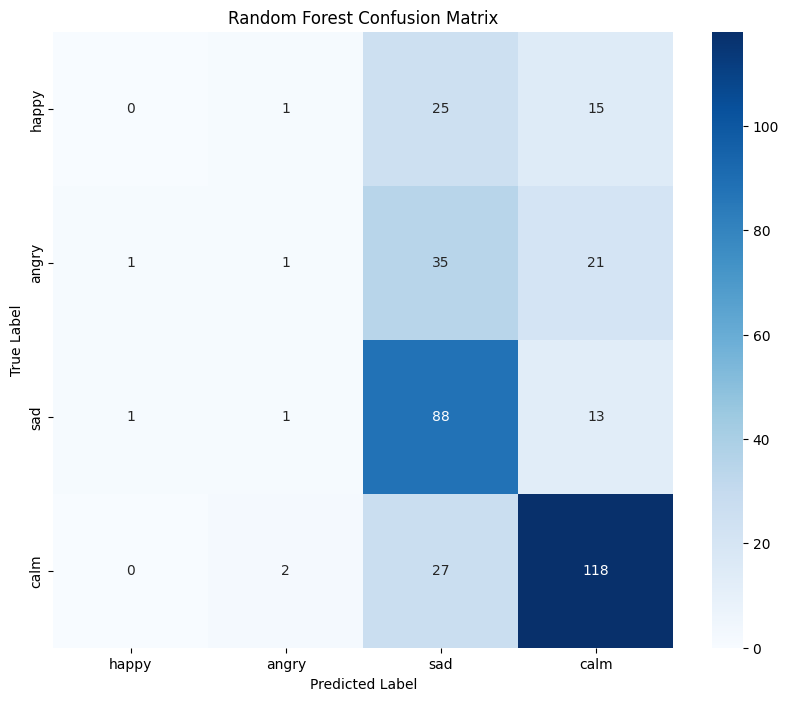


=== CNN Evaluation ===
Accuracy: 45.85%

Classification Report:
              precision    recall  f1-score   support

       happy       0.37      0.61      0.46       103
       angry       0.00      0.00      0.00        41
         sad       0.55      0.66      0.60       147
        calm       0.00      0.00      0.00        58

    accuracy                           0.46       349
   macro avg       0.23      0.32      0.27       349
weighted avg       0.34      0.46      0.39       349


Confusion Matrix:
[[63  0 40  0]
 [27  0 14  0]
 [47  3 97  0]
 [34  0 24  0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


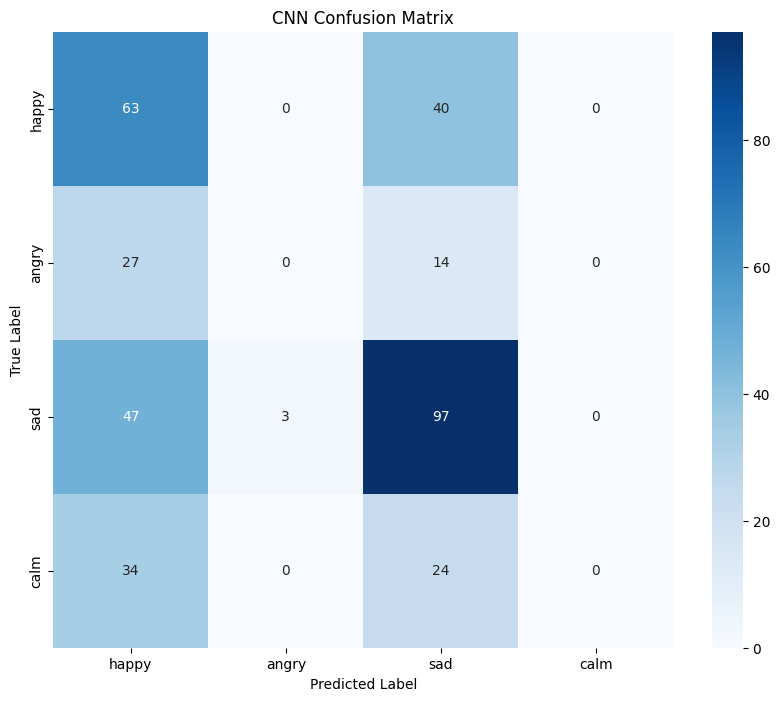

In [3]:
def main():
    """Main function to execute the music emotion classification and recommendation pipeline."""
    # Define file paths
    audio_dir = "/content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/DEAM/MEMD_audio"
    static_annotations_path = "/content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/DEAM/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_1_2000.csv"

    # Create directory for saving models
    model_save_dir = "/content/drive/MyDrive/Colab Notebooks/SEM03-Assignments/Speech Understanding/Project"
    os.makedirs(model_save_dir, exist_ok=True)

    # Load and preprocess data
    X_ml, y_ml, annotations, song_ids = load_deam_data(audio_dir, static_annotations_path)

    # Split data for Random Forest
    X_ml_train, X_ml_test, y_ml_train, y_ml_test = train_test_split(
        X_ml, y_ml, test_size=0.2, random_state=42
    )

    # Train Random Forest with GridSearchCV
    param_grid = {'n_estimators': [100, 200], 'max_depth': [10, 20, None]}
    ml_model = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
    ml_model.fit(X_ml_train, y_ml_train)
    y_ml_pred = ml_model.predict(X_ml_test)

    # Save best Random Forest model
    rf_model_path = os.path.join(model_save_dir, "best_random_forest_model.joblib")
    joblib.dump(ml_model.best_estimator_, rf_model_path)
    print(f"Best Random Forest model saved to: {rf_model_path}")
    print(f"Best Random Forest parameters: {ml_model.best_params_}")
    print(f"Best Random Forest CV score: {ml_model.best_score_:.4f}")

    # Preprocess spectrograms for CNN
    max_length = 128
    X_spectrograms = []
    y_numeric = []
    mood_map = {'happy': 0, 'angry': 1, 'sad': 2, 'calm': 3}

    # Generate spectrograms and labels
    for index, row in annotations.iterrows():
        song_id = int(row['song_id'])
        audio_path = f"{audio_dir}/{song_id}.mp3"
        spectrogram = preprocess_spectrogram(audio_path, max_length=max_length)
        if spectrogram is not None:
            X_spectrograms.append(spectrogram)
            valence, arousal = row[' valence_mean'], row[' arousal_mean']
            if valence > 5 and arousal > 5:
                label = 'happy'
            elif valence < 5 and arousal > 5:
                label = 'angry'
            elif valence < 5 and arousal < 5:
                label = 'sad'
            else:
                label = 'calm'
            y_numeric.append(mood_map[label])

    # Convert to arrays
    X_spectrograms = np.array(X_spectrograms)
    y_numeric = np.array(y_numeric)

    # Split data for CNN
    X_cnn_train, X_cnn_test, y_cnn_train, y_cnn_test = train_test_split(
        X_spectrograms, y_numeric, test_size=0.2, random_state=42
    )

    # Build and train CNN
    input_shape = (128, max_length, 1)
    cnn_model = build_cnn_model(input_shape)

    # Define checkpoint for saving best CNN model
    cnn_model_path = os.path.join(model_save_dir, "best_cnn_model.keras")
    checkpoint = ModelCheckpoint(
        cnn_model_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    # Train CNN
    history = cnn_model.fit(
        X_cnn_train,
        y_cnn_train,
        epochs=20,
        batch_size=32,
        validation_split=0.2,
        callbacks=[checkpoint],
        verbose=1
    )

    # Load best CNN model
    cnn_model = tf.keras.models.load_model(cnn_model_path)
    print(f"Best CNN model saved to: {cnn_model_path}")

    # Evaluate CNN
    y_cnn_pred = np.argmax(cnn_model.predict(X_cnn_test), axis=1)

    # Evaluate both models
    labels = ['happy', 'angry', 'sad', 'calm']
    print_evaluation_metrics("Random Forest", y_ml_test, y_ml_pred, labels)
    plot_confusion_matrix(y_ml_test, y_ml_pred, "Random Forest Confusion Matrix", labels)

    print_evaluation_metrics("CNN", y_cnn_test, y_cnn_pred, labels)
    plot_confusion_matrix(y_cnn_test, y_cnn_pred, "CNN Confusion Matrix", labels)



# Run the pipeline
if __name__ == "__main__":
    main()